# Food-101: Entrenamiento del Modelo

In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [ ]:
# Parametros basicos
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES_TO_USE = 5  # CAMBIAR ESTO: 5, 10, 20, 50, 75, 101
AUTOTUNE = tf.data.AUTOTUNE # Para optimizar el rendimiento del dataset

# Auto-ajustar épocas según número de clases
if NUM_CLASSES_TO_USE <= 10:
    EPOCHS = 5 
elif NUM_CLASSES_TO_USE <= 20:
    EPOCHS = 5
elif NUM_CLASSES_TO_USE <= 50:
    EPOCHS = 8
else:
    EPOCHS = 10

print(f'Configuración:')
print(f'  - Clases a usar: {NUM_CLASSES_TO_USE}')
print(f'  - Épocas: {EPOCHS}')
print(f'  - Batch size: {BATCH_SIZE}')

Configuración:
  - Clases a usar: 5
  - Épocas: 5
  - Batch size: 32


## 1. Cargar datos y crear pipeline

In [ ]:
# Cargar Food-101 dataset
(train_ds, val_ds), info = tfds.load(
    'food101', # nombre del dataset
    split=['train', 'validation'], # dividir en entrenamiento y validación
    with_info=True, # para obtener metadatos
    as_supervised=True # para obtener (imagen, etiqueta)
)
# train_ds es para entrenamiento, val_ds para validación y info tiene metadatos y esto se usa para obtener nombres de clases 
# del dataset (como 'pizza', 'sushi', etc.). 

class_names = info.features['label'].names
print(f'Dataset completo cargado: {len(class_names)} clases')

# Filtrar a solo las primeras N clases si es necesario
if NUM_CLASSES_TO_USE < 101:
    print(f'\nFiltrando a {NUM_CLASSES_TO_USE} clases...')
    
    # Filtrar datasets
    train_ds = train_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE) 
    val_ds = val_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE)
    
    # Actualizar variables
    num_classes = NUM_CLASSES_TO_USE
    class_names = class_names[:NUM_CLASSES_TO_USE]
    
    print(f'Clases seleccionadas: {class_names}')
else:
    num_classes = len(class_names)
    print(f'\nUsando TODAS las {num_classes} clases')

print(f'\nTotal clases en uso: {num_classes}')

Dataset completo cargado: 101 clases

Filtrando a 5 clases...
Clases seleccionadas: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

Total clases en uso: 5


In [ ]:
# Funciones de preprocesamiento y augmentacion
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0 # Normalizar a [0, 1]
    return image, label

data_augmentation = tf.keras.Sequential([ # capa de augmentación para aumentar datos de entrenamiento
    tf.keras.layers.RandomFlip('horizontal'),# aleatorio horizontal
    tf.keras.layers.RandomRotation(0.1),# rotación aleatoria
    tf.keras.layers.RandomZoom(0.1),# zoom aleatorio
])
# La capa de augmentación significa que cada vez que una imagen 
#   se pasa a través de esta capa, se aplican transformaciones aleatorias.
def augment(image, label): # aplicar augmentación
    image = data_augmentation(image, training=True)
    return image, label

In [ ]:
# Crear pipelines de datos
# Los pipelines sirven para optimizar la carga y procesamiento de datos
#   y así evitar cuellos de botella durante el entrenamiento.
train_dataset = ( # Pipeline de entrenamiento
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE) # Preprocesar en paralelo
    .cache() # Cachear en memoria para acelerar
    .shuffle(1000)  # Barajar el dataset
    .map(augment, num_parallel_calls=AUTOTUNE) # Aplicar augmentación en paralelo
    .batch(BATCH_SIZE) # Agrupar en batches
    .prefetch(AUTOTUNE) # Prefetch para optimizar rendimiento
)

val_dataset = ( # Pipeline de validación
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE) # Preprocesar en paralelo
    .cache() # Cachear en memoria para acelerar
    .batch(BATCH_SIZE) # Agrupar en batches
    .prefetch(AUTOTUNE) # Prefetch para optimizar rendimiento
)

print('Pipelines creados')

Pipelines creados


In [ ]:
# Verificar un batch
# Se ocupa verificar que las imágenes estén correctamente preprocesadas
#   y que los valores estén en el rango esperado [0, 1].
for images, labels in train_dataset.take(1):
    print(f'Batch de imagenes: {images.shape}')
    print(f'Batch de labels: {labels.shape}')
    print(f'Rango de valores: [{tf.reduce_min(images):.2f}, {tf.reduce_max(images):.2f}]')

Batch de imagenes: (32, 224, 224, 3)
Batch de labels: (32,)
Rango de valores: [0.00, 1.00]


## 2. Crear modelo (Transfer Learning con MobileNetV2)

In [ ]:
# Modelo base: MobileNetV2 preentrenado en ImageNet
# MobileNetV2 es un modelo eficiente y ligero, ideal para dispositivos con recursos limitados.
# Se usa sin la capa superior (include_top=False) para agregar nuestras propias capas.
# Los pesos preentrenados en ImageNet ayudan a que el modelo aprenda más rápido
base_model = tf.keras.applications.MobileNetV2( 
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar el modelo base para transfer learning
base_model.trainable = False

print('Modelo base cargado: MobileNetV2')
print(f'Pesos congelados: {not base_model.trainable}')

Modelo base cargado: MobileNetV2
Pesos congelados: True


In [8]:
# Construir modelo completo
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3. Compilar y entrenar

In [ ]:
# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # funciona para que al entrenarlo no haya que one-hot encodear las etiquetas
    metrics=['accuracy']
)

print('Modelo compilado con adam optimizer')

Modelo compilado con adam optimizer


In [10]:
# Entrenar el modelo
print(f'Entrenando por {EPOCHS} epocas...')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Entrenando por 5 epocas...
Epoch 1/5
    118/Unknown 52s 340ms/step - accuracy: 0.5175 - loss: 1.1799

/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 472ms/step - accuracy: 0.5184 - loss: 1.1777 - val_accuracy: 0.7840 - val_loss: 0.5793
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.7656 - loss: 0.6321 - val_accuracy: 0.8208 - val_loss: 0.4763
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - accuracy: 0.8036 - loss: 0.5348 - val_accuracy: 0.8208 - val_loss: 0.4691
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 39s 330ms/step - accuracy: 0.8109 - loss: 0.5076 - val_accuracy: 0.8328 - val_loss: 0.4260
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.8301 - loss: 0.4701 - val_accuracy: 0.8488 - val_loss: 0.3963


## 4. Visualizar entrenamiento

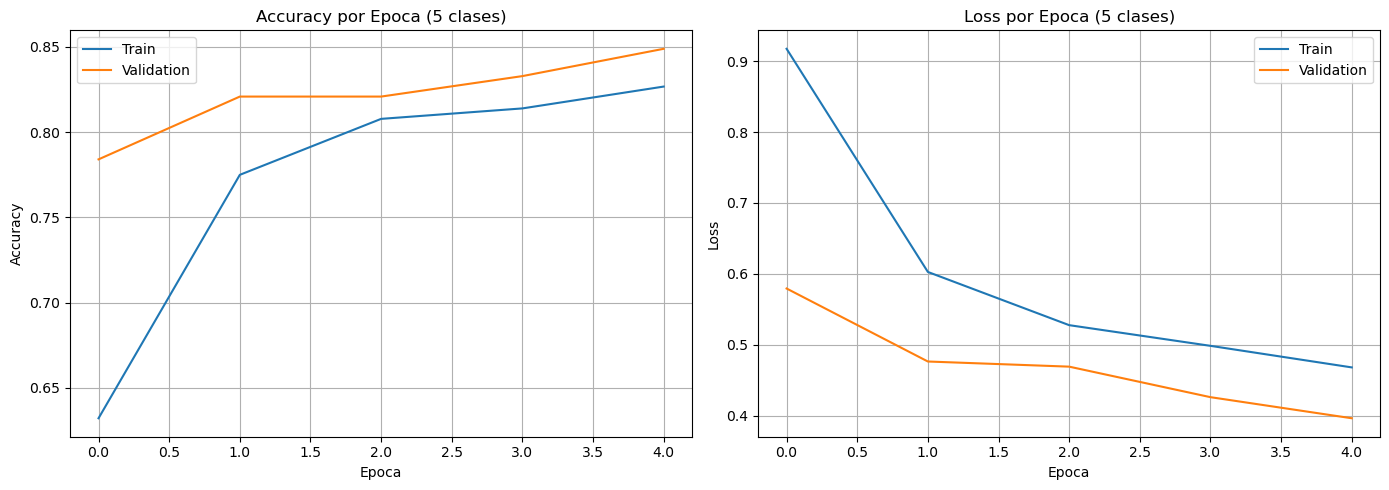

In [14]:
# Graficar accuracy y loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title(f'Accuracy por Epoca ({NUM_CLASSES_TO_USE} clases)')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title(f'Loss por Epoca ({NUM_CLASSES_TO_USE} clases)')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 5. Evaluar modelo en validacion

In [ ]:
# Evaluar en el conjunto de validacion
test_loss, test_acc = model.evaluate(val_dataset)
print(f'\nValidation Loss: {test_loss:.4f}')
print(f'Validation Accuracy: {test_acc:.4f}')
print(f'\nMejora sobre random (1/{num_classes}): {test_acc / (1/num_classes):.1f}x') 

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.8595 - loss: 0.3598

Validation Loss: 0.3963
Validation Accuracy: 0.8488

Mejora sobre random (1/5): 4.2x


In [ ]:
# Obtener predicciones en validacion
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0) 
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f'Predicciones generadas: {len(y_pred)}')

Generando predicciones...
Predicciones generadas: 1250


## 6. Analizar resultados (Confusion Matrix)

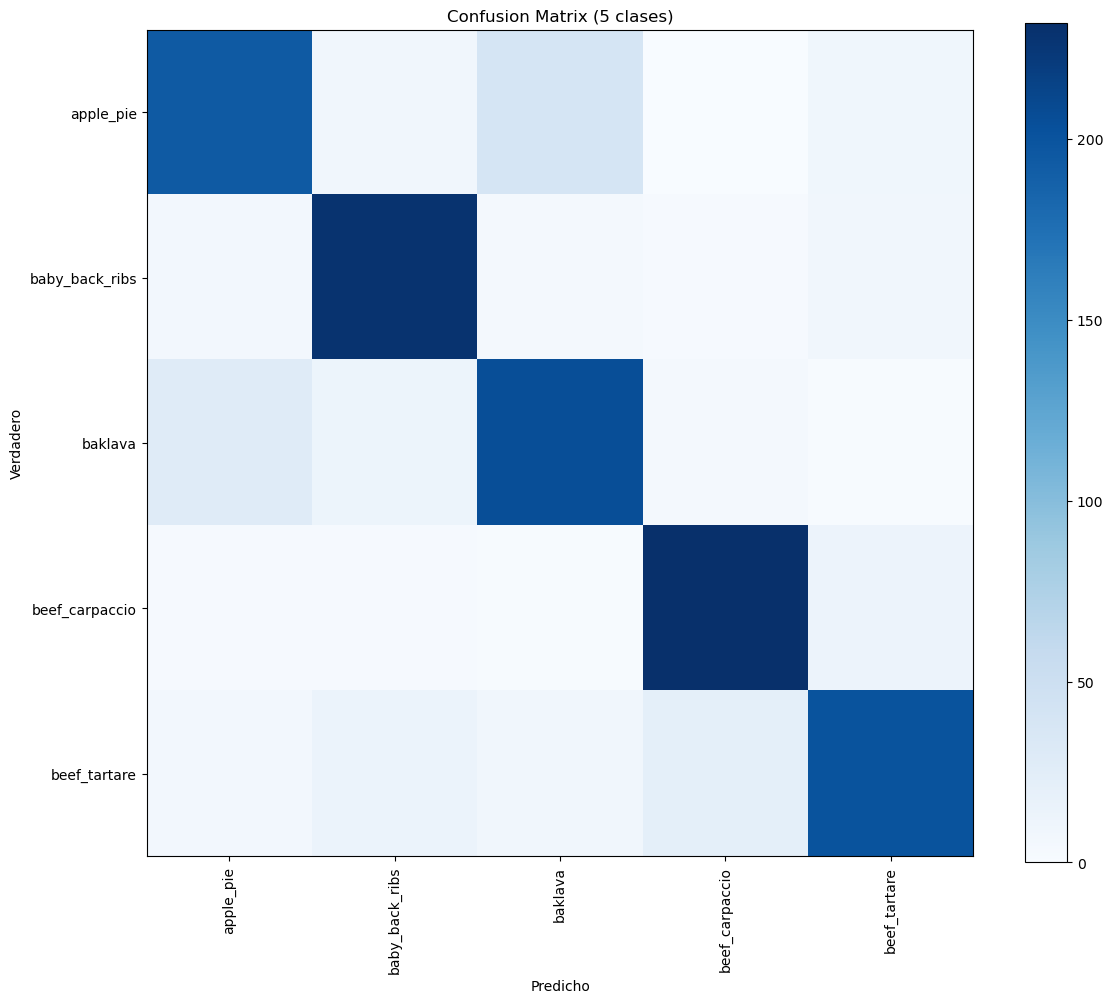

Diagonal (predicciones correctas): 1061 / 1250


In [18]:
# Matriz de confusion (mostrar todas las clases si son pocas, o top 20 si son muchas)
display_n = num_classes if num_classes <= 20 else 20
mask = (y_true < display_n) & (y_pred < display_n)
y_true_display = y_true[mask]
y_pred_display = y_pred[mask]

cm = confusion_matrix(y_true_display, y_pred_display, labels=range(display_n))

# Visualizar
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f'Confusion Matrix ({display_n} clases)')
plt.colorbar()
tick_marks = np.arange(display_n)
plt.xticks(tick_marks, [class_names[i][:15] for i in range(display_n)], rotation=90)
plt.yticks(tick_marks, [class_names[i][:15] for i in range(display_n)])
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

print(f'Diagonal (predicciones correctas): {np.diag(cm).sum()} / {cm.sum()}')

In [19]:
# Classification report
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    digits=3
)

print('\nClassification Report:\n')
print(report)

# Guardar reporte
with open('results/classification_report.txt', 'w') as f:
    f.write(report)


Classification Report:

                precision    recall  f1-score   support

     apple_pie      0.822     0.776     0.798       250
baby_back_ribs      0.864     0.916     0.889       250
       baklava      0.795     0.820     0.807       250
beef_carpaccio      0.896     0.928     0.912       250
  beef_tartare      0.866     0.804     0.834       250

      accuracy                          0.849      1250
     macro avg      0.849     0.849     0.848      1250
  weighted avg      0.849     0.849     0.848      1250



## 7. Visualizar predicciones

In [20]:
# Obtener algunas imagenes con sus predicciones
sample_images = []
sample_labels = []
sample_predictions = []

for images, labels in val_dataset.take(3):
    predictions = model.predict(images, verbose=0)
    sample_images.extend(images.numpy())
    sample_labels.extend(labels.numpy())
    sample_predictions.extend(np.argmax(predictions, axis=1))

# Encontrar predicciones correctas e incorrectas
correct_indices = [i for i in range(len(sample_labels)) if sample_labels[i] == sample_predictions[i]]
incorrect_indices = [i for i in range(len(sample_labels)) if sample_labels[i] != sample_predictions[i]]

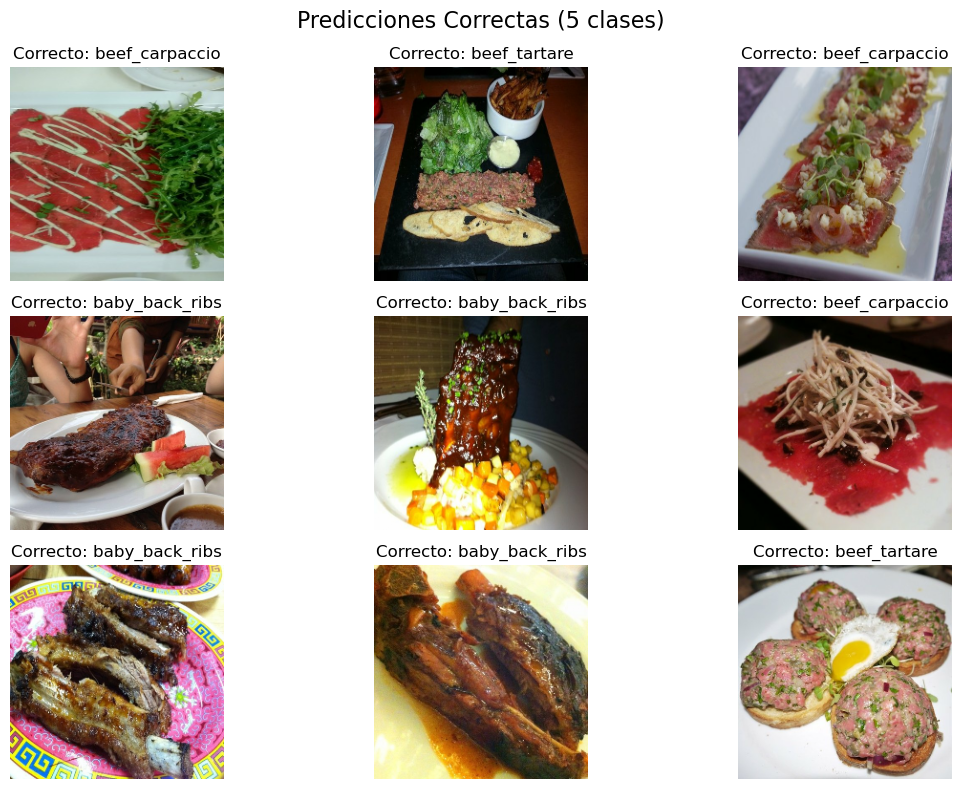

In [22]:
# Visualizar predicciones correctas
plt.figure(figsize=(12, 8))
for i in range(min(9, len(correct_indices))):
    idx = correct_indices[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[idx])
    plt.title(f'Correcto: {class_names[sample_labels[idx]][:15]}')
    plt.axis('off')
plt.suptitle(f'Predicciones Correctas ({NUM_CLASSES_TO_USE} clases)', fontsize=16)
plt.tight_layout()
plt.show()

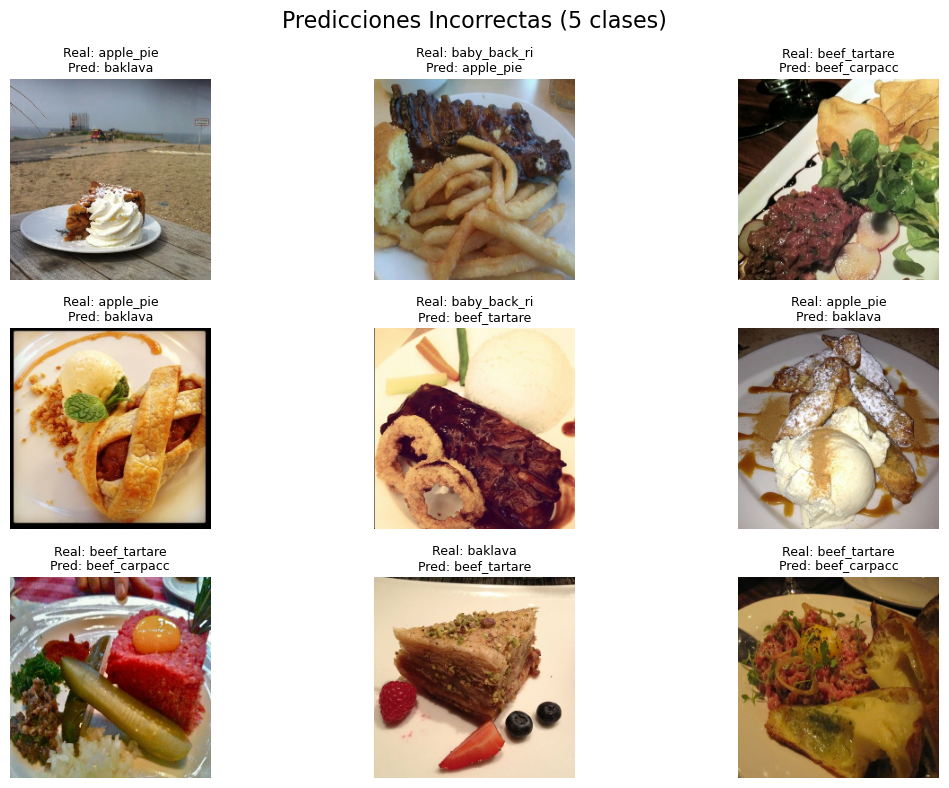

In [24]:
# Visualizar predicciones incorrectas
if len(incorrect_indices) > 0:
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(incorrect_indices))):
        idx = incorrect_indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[idx])
        plt.title(f'Real: {class_names[sample_labels[idx]][:12]}\nPred: {class_names[sample_predictions[idx]][:12]}', 
                  fontsize=9)
        plt.axis('off')
    plt.suptitle(f'Predicciones Incorrectas ({NUM_CLASSES_TO_USE} clases)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('No hay predicciones incorrectas en la muestra')

## 8. Guardar todo (modelo + resultados)

In [25]:
# Guardar el modelo con nombre versionado
model_name = f'models/food_model_v{NUM_CLASSES_TO_USE}classes.h5'
model.save(model_name)
print(f'Modelo guardado en: {model_name}')

Modelo guardado en: models/food_model_v5classes.h5


In [26]:
# Guardar historial de entrenamiento versionado
import os
results_dir = f'results/v{NUM_CLASSES_TO_USE}classes'
os.makedirs(results_dir, exist_ok=True)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{results_dir}/training_history.csv', index=False)
print(f'Historial guardado en: {results_dir}/training_history.csv')

Historial guardado en: results/v5classes/training_history.csv


In [27]:
# Guardar matriz de confusion completa
cm_full = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_df = pd.DataFrame(cm_full, index=class_names, columns=class_names)
cm_df.to_csv(f'{results_dir}/confusion_matrix_full.csv')
print(f'Confusion matrix guardada en: {results_dir}/confusion_matrix_full.csv')

# Guardar classification report
with open(f'{results_dir}/classification_report.txt', 'w') as f:
    f.write(report)
print(f'Classification report guardado en: {results_dir}/classification_report.txt')

Confusion matrix guardada en: results/v5classes/confusion_matrix_full.csv
Classification report guardado en: results/v5classes/classification_report.txt


## 9. Resumen final

In [28]:
print('='*60)
print('RESUMEN DEL ENTRENAMIENTO')
print('='*60)
print(f'Modelo: MobileNetV2 + Transfer Learning')
print(f'Dataset: Food-101 ({num_classes} clases)')
print(f'Epocas: {EPOCHS}')
print(f'Batch size: {BATCH_SIZE}')
print(f'\nResultados:')
print(f'  Training Accuracy:   {history.history["accuracy"][-1]:.4f}')
print(f'  Validation Accuracy: {test_acc:.4f}')
print(f'  Training Loss:       {history.history["loss"][-1]:.4f}')
print(f'  Validation Loss:     {test_loss:.4f}')
print(f'\nMejora sobre random: {test_acc / (1/num_classes):.1f}x')
print('='*60)
print('\nProximos pasos:')
print('  1. Entrenar mas epocas (10-15)')
print('  2. Fine-tuning (descongelar capas del base_model)')
print('  3. Probar modelos mas grandes (EfficientNet)')
print('  4. Analizar clases con peor performance')
print('='*60)

RESUMEN DEL ENTRENAMIENTO
Modelo: MobileNetV2 + Transfer Learning
Dataset: Food-101 (5 clases)
Epocas: 5
Batch size: 32

Resultados:
  Training Accuracy:   0.8267
  Validation Accuracy: 0.8488
  Training Loss:       0.4680
  Validation Loss:     0.3963

Mejora sobre random: 4.2x

Proximos pasos:
  1. Entrenar mas epocas (10-15)
  2. Fine-tuning (descongelar capas del base_model)
  3. Probar modelos mas grandes (EfficientNet)
  4. Analizar clases con peor performance
